## Monthly Averaging, Anomalies and Climate Indices.

The annual cycle and anomaly calculations are usually the starting point for climatological analysis. 

There are many great books on Climate Statistics such as von Storch and Navarra's "Analysis of Climate Variability" and Wilks' "Statistical Methods in the Atmospheric Sciences", just to name a few. If you are starting now and want to go for it, these are the books you should start with.

So, with the lessons from [the last notebook](https://github.com/willyhagi/climate-statistics/blob/master/cartopy_plot.ipynb) still fresh, let's get into more complicated things.

In [1]:
import matplotlib.pyplot   as plt
import cartopy.crs         as ccrs
import cartopy.feature     as cf
import cartopy             as cartopy
import numpy               as np
import xarray              as xr
import datetime

from calendar              import month_name
from cartopy.mpl.ticker    import LongitudeFormatter, LatitudeFormatter

That's all we will need here. We will continue to use GPCC Precipitation dataset as we did before, focusing on South America.

In [2]:
dset  =  xr.open_dataset('precip.mon.total.1x1.v7.nc')
var   =  dset['precip'][:,:,:]
lat   =  dset['lat'][:]
lon   =  dset['lon'][:]


# selecting the area for south america
lat1  =  12 
lat2  =  -50 
lon1  =  270 
lon2  =  330  


# selecting time
time1 = '1981-1-1'
time2 = '2010-12-1'


# converting to numpy array
lon  =  var.sel(lon=slice(lon1,lon2))  
lon  =  np.asarray(lon.lon.values)

lat  =  var.sel(lat=slice(lat1,lat2)) 
lat  =  np.asarray(lat.lat.values)


var  =  var.sel( lat=slice(lat1, lat2),
                 lon=slice(lon1, lon2), 
                 time=slice(time1, time2))

As you can see, we can select both the space and time for our data easily with xarray. Let's check the shape of our sliced precipitation dataset just to be sure.

In [3]:
print (var.shape)

(360, 62, 60)


Everything is right how it should be. We have 360 months for the 1981-2010 period and the area is the same of the last notebook.

Things will get far easier now with xarray's 'groupby' function. If you're familiar with the Pandas package, you know what I'm saying.

To make the climatology for the period we chose, you just have to do:

In [4]:
clim  =  var.groupby('time.month').mean('time')

In [5]:
print (clim.shape)

(12, 62, 60)


Cool, isn't it? We clearly have one value for each calendar month, and that's our annual cycle right there. 

But things can't stop now, let's calculate the anomalies using the climatological values we just got.

(by the way, 'anomaly' is just the weird name climatologists gave to the absolute deviation from statistics)

In [6]:
anom  =  var.groupby('time.month') - clim

In [7]:
print (anom.shape)

(360, 62, 60)


We are back with the 360 values, but instead of the original monthly precipitation values these are now our anomalies. That means each one of the original values were subtracted for the corresponding climatological value (january 1981 - climatological january... and so on).

Ok, to the fun part now. Let's plot it!

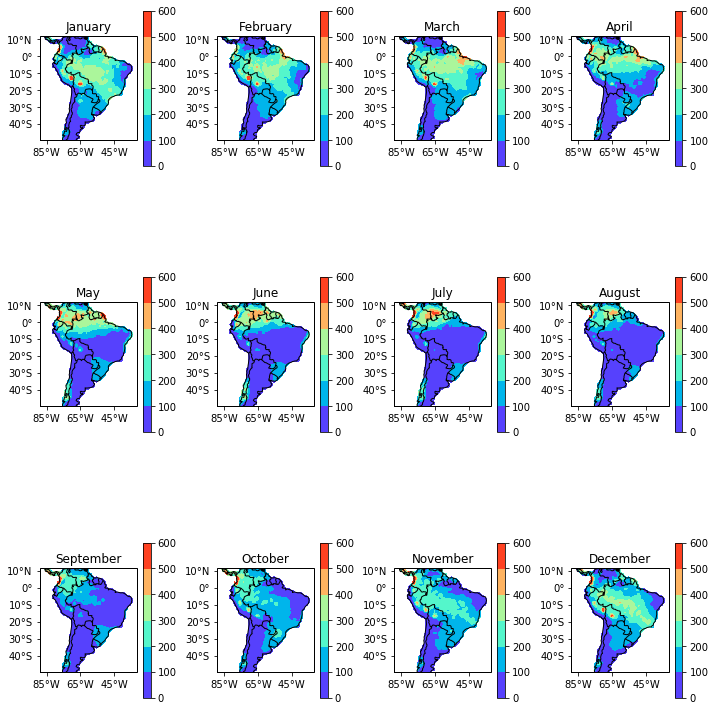

In [8]:
interval  = np.arange(0,700,100)
proj      =  ccrs.PlateCarree()     # cartopy projection

fig, axes = plt.subplots(figsize=(10,12),nrows = 3, 
						 ncols = 4, subplot_kw={'projection': proj})

axes = axes.flatten()

for i, month in enumerate(range(1,13,1)):
    ax = axes[i]
#    ax.set_extent([280, 325, -50, 12], proj)       # select lon/lat
    ax.add_feature(cf.BORDERS,zorder=2,edgecolor='k')       # borders
    ax.add_feature(cartopy.feature.COASTLINE)               # coastline
    x_lons = np.arange(-85,-15,20)
    y_lats = np.arange(-70,50,10)
    tick_fs = 16
    ax.set_xticks(x_lons, minor=False, crs=proj)
    ax.set_yticks(y_lats, minor=False, crs=proj)
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                   number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_title(month_name[i+1])  # month titles
    data = ax.contourf(lon,lat,clim[i,:,:],interval,
                       transform = proj,
                       cmap = 'rainbow')
    fig.colorbar(data, ax=ax, shrink=0.5)

plt.tight_layout()

plt.show()

This last part might look big and complicated but trust me, you don't want to write code to get each one of the months into each subplot box... You'll end up with a huge code full of unnecessary repetitions!

So don't be scared. But if you are, I do recommend you to learn the 'for' control structure a little bit more.

The last part of our lesson is ['Climate Indices'](https://www.esrl.noaa.gov/psd/data/climateindices/list/). Usually they are obtained from simple averages over certain important monitoring areas. We will try to make our own 'Niño 3' index with the xarray tools. 

The idea is the same to select the area and make the calculations:

In [9]:
# niño 3 region
lat1 = 5. 
lat2 = -5. 
lon1 = 210.
lon2 = 270.  

nino3  =  var.sel( lat=slice(lat1, lat2),
                 lon=slice(lon1, lon2), 
                 time=slice(time1, time2))

nino3_avg  =  nino3.groupby('time.month').mean('time')

nino3_anom =  nino3.groupby('time.month') - nino3_avg

Our index is not yet ready. For this we have to make an average over the Niño 3 area (that is, over the grid points of our area), resulting in a time series.

This can be done easily with Xarray as well.

In [10]:
nino3_ind  =  nino3_anom.mean(dim = ('lat','lon'), skipna = True)
nino3_ind  =  np.asarray(nino3_ind)

With 'np.asarray' we are converting from an xarray dataset to numpy array, giving us the option to save it and/or manipulate the index in a more flexible way (this is just one solution among many, not the only one).

Since now you already have the index, you can proceed with whatever analysis you might want to do with it (have in mind that you have just the step 2 of Trenberth (1997) definition of the Niño 3 index).

And by the way if you're going to use the script associated with this notebook, everything we just did is contained on Classes. If you're still not familiar with classes, you can see a simple introduction [here.](https://github.com/willyhagi/climate-statistics/blob/master/rad_laws.ipynb)

## REFERENCES

1 - Von Storch, Hans, and Antonio Navarra, eds. Analysis of climate variability: Applications of statistical techniques proceedings of an autumn school organized by the Commission of the European Community on Elba from October 30 to November 6, 1993. Springer Science & Business Media, 2013.

2 - Wilks, Daniel S. Statistical methods in the atmospheric sciences. Vol. 100. Academic press, 2011.

3 - Trenberth, Kevin E. "The definition of el nino." Bulletin of the American Meteorological Society 78.12 (1997): 2771-2777.

## RECOMMENDED READING

1 - Bombardi, Rodrigo José, and Leila Maria Véspoli de Carvalho. "Simple Practices in Climatological Analyses: A Review." Revista Brasileira de Meteorologia 32.3 (2017): 311-320.